The purpose of this notebook is to show that our ideas work on a different dataset and also to showcase the `wandb` integration.

# Setup

In [ ]:
from diffusers import UNet2DModel

import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from tinyai.datasets import *
from tinyai.conv import *
from tinyai.learner import *
from tinyai.activations import *
from tinyai.init import *
from tinyai.sgd import *
from tinyai.resnet import *
from tinyai.augment import *
from tinyai.accel import *

In [ ]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

In [ ]:
xl,yl = 'img','label'
name = "cifar10"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o)-0.5 for o in b[xl]]

bs = 32
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=12)

In [ ]:
dt = dls.train
xb,yb = next(iter(dt))

In [ ]:
xb[0].shape

torch.Size([3, 32, 32])

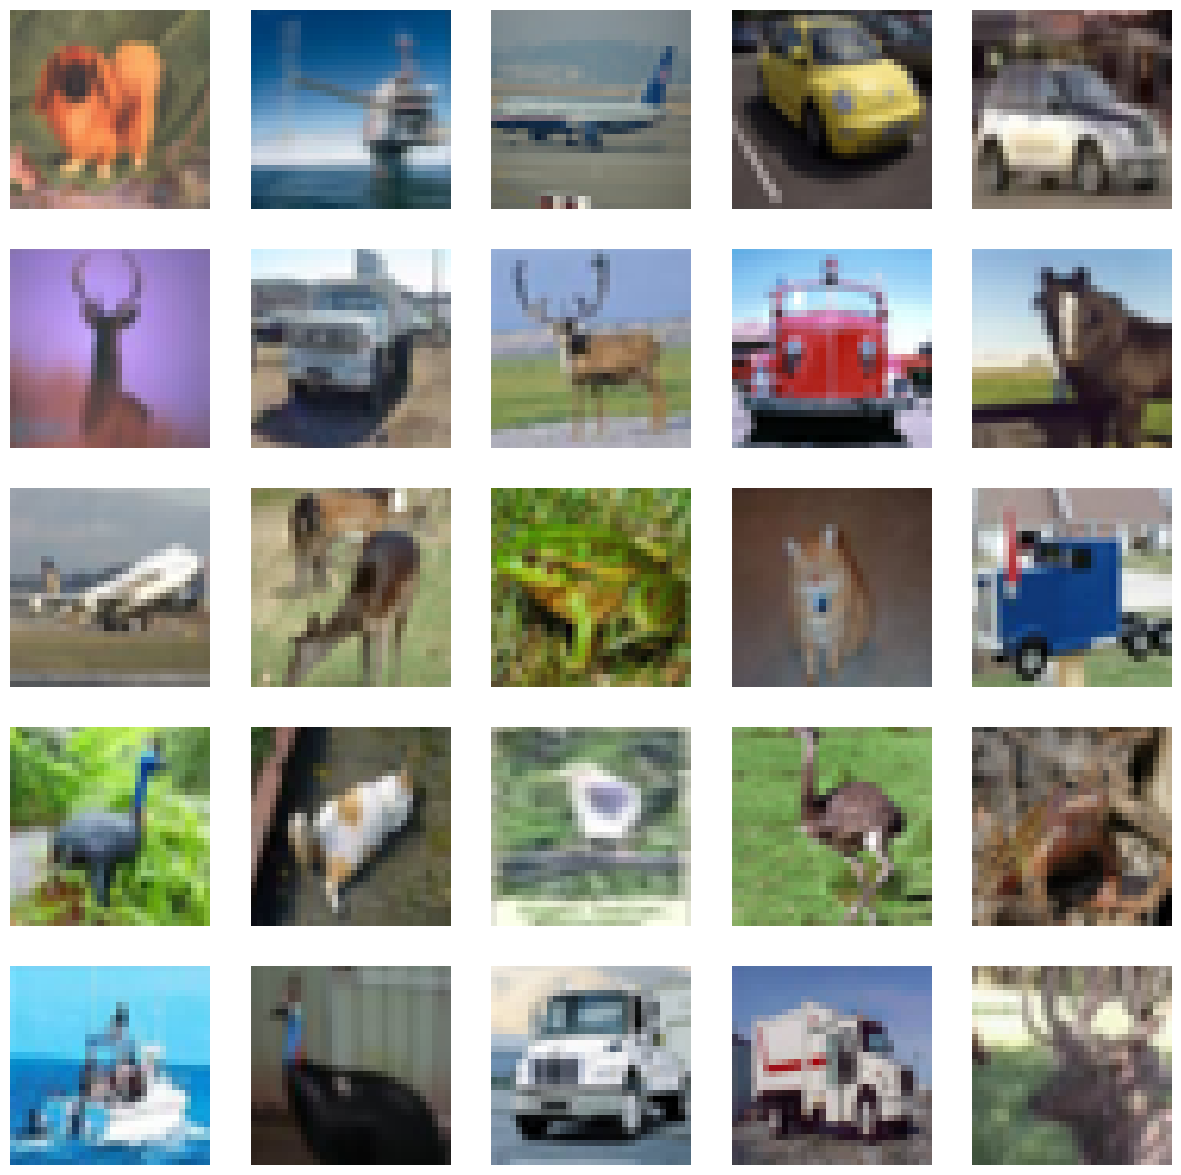

In [ ]:
show_images(xb[:25]+0.5)

In [ ]:
from types import SimpleNamespace
def linear_sched(betamin=0.0001,betamax=0.02,n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())

In [ ]:
n_steps = 1000
lin_abar = linear_sched(betamax=0.01)
## SimpleNamesace allows us to do the .a .abar .sig calls
alphabar = lin_abar.abar
alpha = lin_abar.a
sigma = lin_abar.sig

In [ ]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [ ]:
(xt,t),ε = noisify(xb[:25],alphabar)
t

tensor([920, 412, 590, 498, 903, 157, 881, 765, 262, 410, 339, 418, 615, 515,
        750, 481, 935, 824, 199,  18, 960, 712, 246, 363, 529])

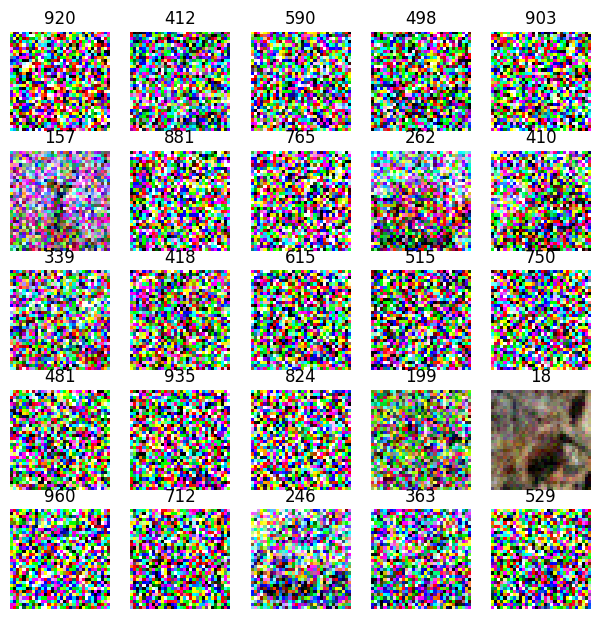

In [ ]:
titles = fc.map_ex(t[:25], '{}')
show_images(xt[:25].clip(-0.5, 0.5) + 0.5, imsize=1.5, titles=titles)

# Training

In [ ]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)
def dl_ddpm(ds, nw=2): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=nw)

In [ ]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

We need to provide the number of `in_channels` since our images are in `RGB`

In [ ]:
# The model we've been using for FashionMNIST
model = UNet(in_channels=3, out_channels=3, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
sum(p.numel() for p in model.parameters())

15891907

In [ ]:
# The default is a much larger model:
model = UNet(in_channels=3, out_channels=3)
sum(p.numel() for p in model.parameters())

274056163

In [ ]:
clean_mem() # Free up some memory

We'll use the bigger model for cifar10 since the images are more complex than FashionMNIST.

In [ ]:
lr = 1e-3
epochs = 1
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=3, out_channels=3)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.055,0,train
0.027,0,eval


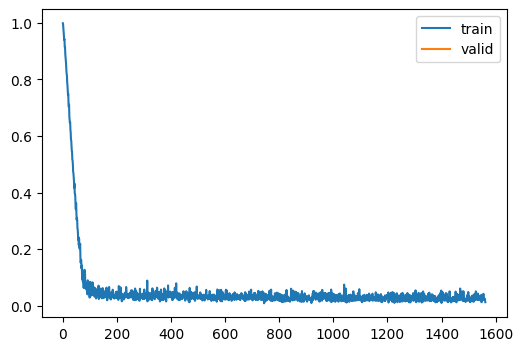

In [ ]:
learn.fit(epochs)

In [ ]:
@torch.no_grad()
def sample(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.float().cpu())
    return preds

In [ ]:
# %%time
samples = sample(model, (bs, 3, 32, 32))

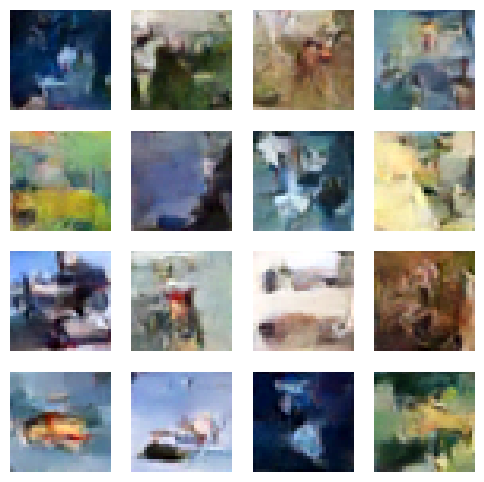

In [ ]:
s = (samples[-1] + 0.5).clamp(0,1)
show_images(s[:16], imsize=1.5)

# W&B CB

In [ ]:
# uncomment if you dont have wandb
# ! pip install wandb

a fix to get it working

In [ ]:
import wandb

class WandBCB(MetricsCB):
    order=100
    def __init__(self, config, *ms, project='ddpm_cifar10', **metrics):
        fc.store_attr()
        super().__init__(*ms, **metrics)

    def before_fit(self, learn): wandb.init(project=self.project, config=self.config)
    def after_fit(self, learn): wandb.finish()

    def _log(self, d):
        # if self.training:
        if d.get('train') == 'train':
            wandb.log({'train_'+m:float(d[m]) for m in self.all_metrics})
        else:
            wandb.log({'val_'+m:float(d[m]) for m in self.all_metrics})
            wandb.log({'samples':self.sample_figure(learn)})
        print(d)


    def sample_figure(self, learn):
        with torch.no_grad():
            samples = sample(learn.model, (16, 3, 32, 32))
        s = (samples[-1] + 0.5).clamp(0,1)
        plt.clf()
        fig, axs = get_grid(16)
        for im,ax in zip(s[:16], axs.flat): show_image(im, ax=ax)
        return fig

    def after_batch(self, learn):
        super().after_batch(learn)
        wandb.log({'loss':learn.loss})

In [ ]:
lr = 1e-3
epochs = 10
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
wandbcb =  WandBCB(config={'lr':lr, 'epochs':epochs, 'comments':'default unet logging test'})
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), wandbcb, BatchSchedCB(sched)]
model = model = UNet(in_channels=3, out_channels=3)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

# Run win new GPU 🥳

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.05623


{'loss': '0.062', 'epoch': 0, 'train': 'train'}
{'loss': '0.029', 'epoch': 0, 'train': 'eval'}
{'loss': '0.029', 'epoch': 1, 'train': 'train'}
{'loss': '0.028', 'epoch': 1, 'train': 'eval'}
{'loss': '0.027', 'epoch': 2, 'train': 'train'}
{'loss': '0.027', 'epoch': 2, 'train': 'eval'}
{'loss': '0.026', 'epoch': 3, 'train': 'train'}
{'loss': '0.026', 'epoch': 3, 'train': 'eval'}
{'loss': '0.026', 'epoch': 4, 'train': 'train'}
{'loss': '0.025', 'epoch': 4, 'train': 'eval'}
{'loss': '0.025', 'epoch': 5, 'train': 'train'}
{'loss': '0.026', 'epoch': 5, 'train': 'eval'}
{'loss': '0.025', 'epoch': 6, 'train': 'train'}
{'loss': '0.025', 'epoch': 6, 'train': 'eval'}
{'loss': '0.024', 'epoch': 7, 'train': 'train'}
{'loss': '0.024', 'epoch': 7, 'train': 'eval'}
{'loss': '0.024', 'epoch': 8, 'train': 'train'}
{'loss': '0.024', 'epoch': 8, 'train': 'eval'}
{'loss': '0.024', 'epoch': 9, 'train': 'train'}
{'loss': '0.025', 'epoch': 9, 'train': 'eval'}


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


loss,▃▃▄▇█▅▃▄▃▄▁▄▆▂▃▆▃▃▃▂▆▄▁▂▂▃▅▁▄▂▄▂▆▃▂▃▁▂▁▃
train_loss,█▂▂▁▁▁▁▁▁▁
val_loss,█▇▅▄▂▄▂▁▁▂
loss,0.02274
train_loss,0.024
val_loss,0.025


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

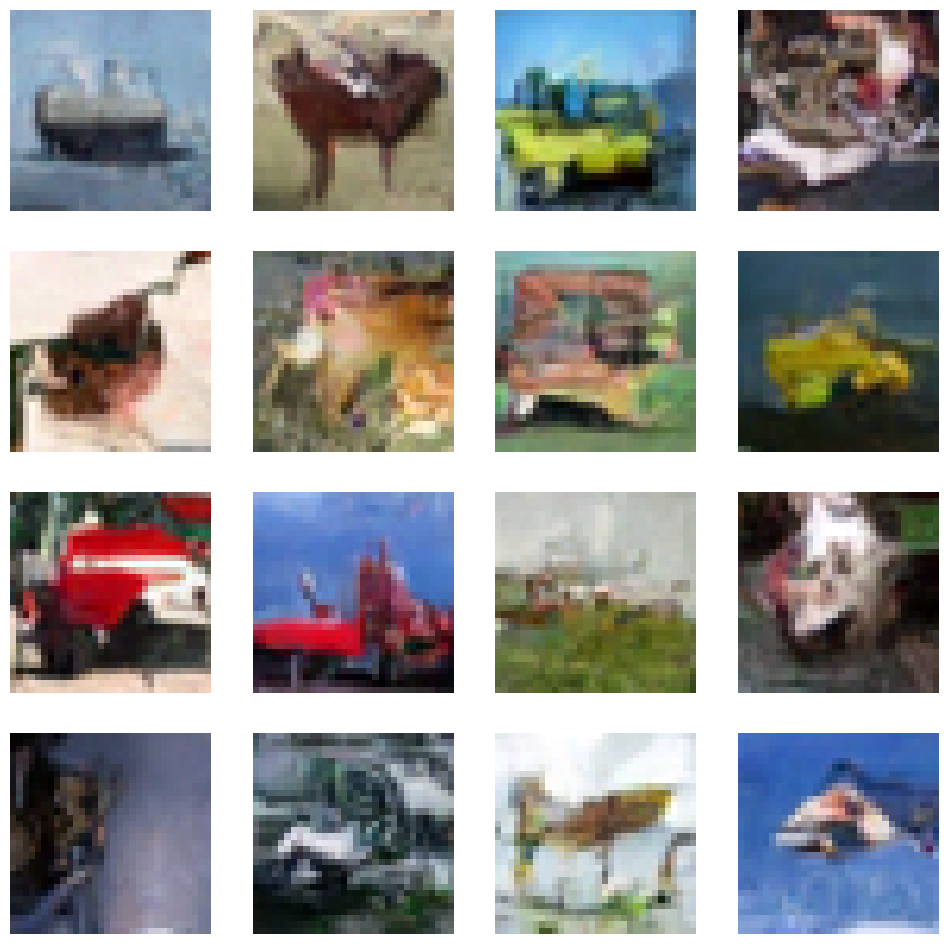

In [ ]:
learn.fit(epochs)